In [2]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util import util
from tensorflow import keras

figsize = (20, 4.5)

# Loading data
data = util.load_data(data_folder='data', fnames=['train_FD004'])
dt_in = list(data.columns[3:-1])

# Split training and test set
tr, ts = util.split_train_test_machines(data, tr_ratio=0.75, seed=42)
tr_mcn = tr["machine"].unique()
ts_mcn = ts["machine"].unique()
# Rescale
tr_s, ts_s, nparams = util.rescale_CMAPSS(tr, ts)
# Load pre-trained model
nn2 = keras.models.load_model("mlp_model.keras")
# Obtain the predictions
tr_pred = nn2.predict(tr_s[dt_in], verbose=0).ravel() * nparams['trmaxrul']
ts_pred = nn2.predict(ts_s[dt_in], verbose=0).ravel() * nparams['trmaxrul']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Policy Threshold Calibration

## Our Current Situation

**The results so far are not comforting**

...But it's worth seeing what is going on _over time_

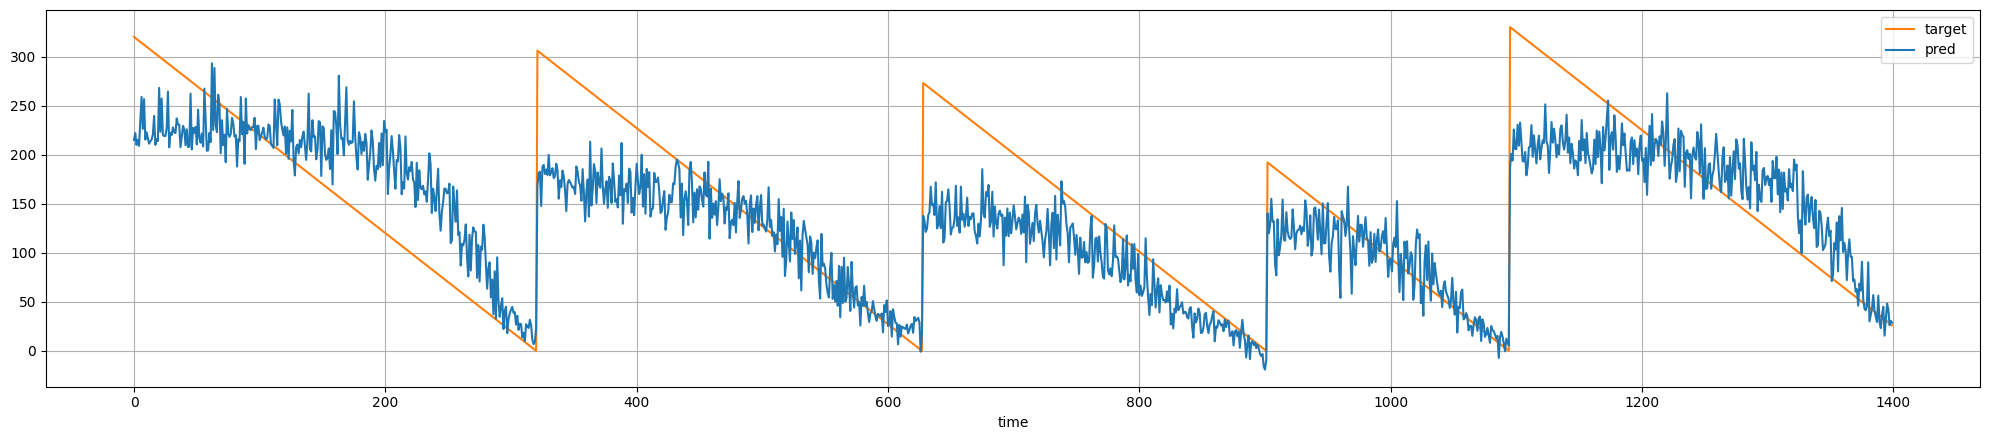

In [3]:
stop = 1400
util.plot_rul(tr_pred[:stop], tr['rul'][:stop], figsize=figsize)

...And we get the same shapes also on the validation and test set 

## ...And How to Go Forward

**Our goal is _not_ to regress RUL values with high accuracy**

...But rather to define a maintenance _policy_ in the form:

$$
f(x, w) < \theta \ \Rightarrow \text{ trigger maintenance}
$$

* For this, we just need to _stop at the right time_

**Our model...**

Makes large estimation errors when the RUL is high

* ...But we do not care about those!

Works reasonably well for low RUL values

* ...I.e. exactly where it matters

## Threshold Calibration as an Optimization Problem

**Given a RUL estimator**

...We can choose when to trigger maintenance by calibrating $\theta$

* This is in fact an(other) _optimization problem_
* ...And to formulate it we need a _cost function_

**Our cost function will rely on this simplified cost model:**

* Whenever an engine _operates_ for a time step, we gain a _profit_ of 1 unit
* A failure costs $C$ units (i.e. the equivalent of $C$ operation days)
* We never trigger maintenance before $s$ time steps (safe interval)

Some comments:

* $C$ is actually an offset over the cost of maintenance
* The last rule mimics using preventive maintenance as a fail-safe mechanism

## The Cost Function

**Normally, we would determine $s$ and $C$ by talking to a domain expert**

...In our case wi well pick reasonable values based on our data

* First, we collect all failure times:

In [4]:
tr_failtimes = tr.groupby('machine')['cycle'].max()

* Then, we define $s$ and $C$ based on statistics:

In [5]:
safe_interval = tr_failtimes.min()
maintenance_cost = tr_failtimes.max()

* For the safe interval $s$, we choose the minimum failure time
* For the maintenance cost $C$ we choose the largest failure time

We are taling about jet engines, so failing is BAD

## Solving the Calibration Problem

**We can _sample a range_ of values for the $\theta$ parameter**

...Then simply pick the value with the smallest cost

* The code in `optimize_threshold` can also plot the corresponding cost surface

Optimal threshold for the training set: 15.39


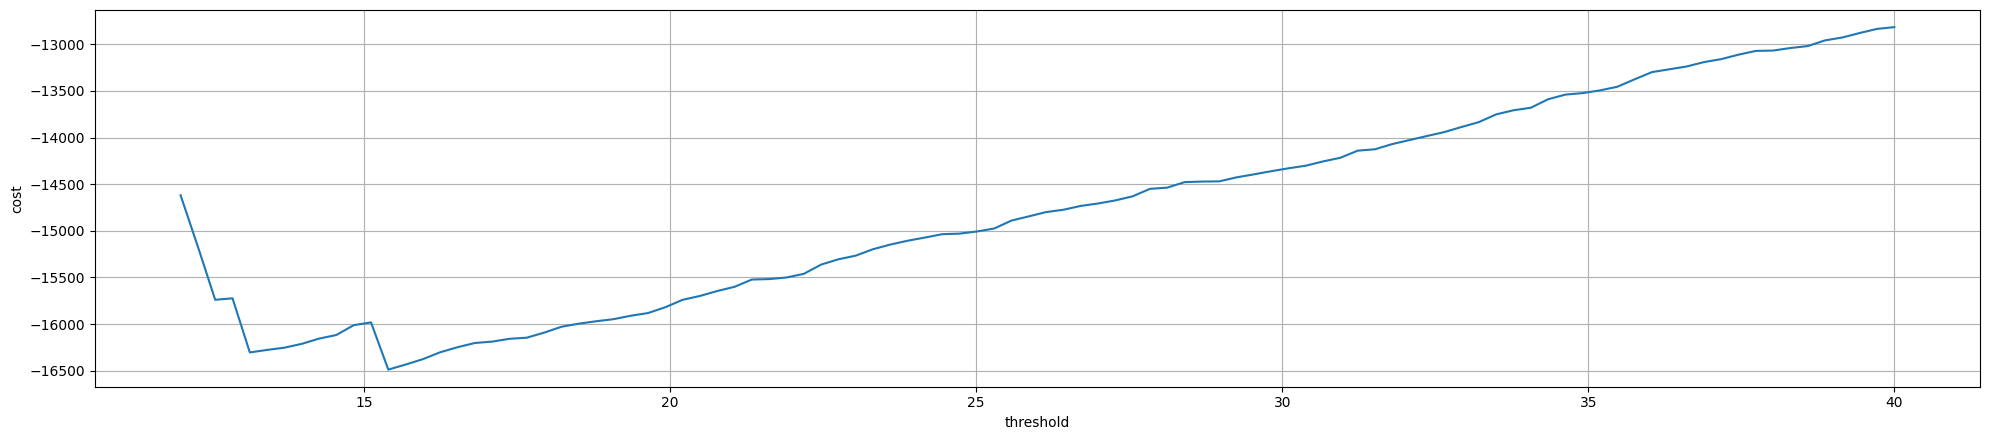

In [6]:
cmodel = util.RULCostModel(maintenance_cost, safe_interval)
th_range = np.linspace(12, 40, 100)
tr_thr = util.optimize_threshold(tr['machine'].values, tr_pred, th_range, cmodel, plot=True, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr:.2f}')

## Evaluation

**Finally, we can check how we are doing on the test set:**

In [7]:
tr_c, tr_f, tr_sl = cmodel.cost(tr['machine'].values, tr_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, tr_thr, return_margin=True)
print(f'Cost: {tr_c} (training), {ts_c} (test)')

Cost: -16487 (training), -6214 (test)


We can also evaluate the margin for improvement:

In [8]:
print(f'Avg. fails: {tr_f/len(tr_mcn):.2f} (training), {ts_f/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {tr_sl/len(tr_mcn):.2f} (training), {ts_sl/len(ts_mcn):.2f} (test)')

Avg. fails: 0.00 (training), 0.00 (test)
Avg. slack: 27.73 (training), 25.30 (test)


* Slack = distance between when we stop and the failure
* The results are actually quite good and we also generalize fairly well

## Some Considerations

**In principle, RUL regression is a very hard problem**

* Our linearly decreasing RUL assumption is just a rough oversimplification
* ...RUL is inherently subject to stochastisticy
* ...And depends on the how the machine _will be_ used

**But we _don't care_, since RUL prediction was _not our true problem_**

The real problem involved both _prediction and optimization_

* We had to optimize the NN parameters (to obtain good predictions)
* We had to optimize the threshold

The ultimate goal was to _reduce maintenance cost_

**It's worth to keep in mind _the big picture_**

* In a "predict, then optimize" setting
* ...Quality should be judged on the final cost